# LSTM

LSTM-RNN to predict net migration.

In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset
#from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device}")

Using cpu


In [250]:
data = pd.read_csv("../data/final/preprocessed.csv", index_col=[0])

# Also MinMax-scaling what will be target; but saving orig. min and
#  max so we can rescale later:
omin, omax = data["net_migration"].min(), data["net_migration"].max()
data["net_migration"] = minmax_scale(data["net_migration"])

# Drop 2022 & 2023
data = data[data["year"] < 2022]

data = data.sort_values(["iso3", "year"]).reset_index(drop=True)

## Data Prep

Here we have to make up our mind on what to predict:

* **Predict the full sequence:** Build a model that takes as input the features for an entire time series for a dyad & predicts how migration for that dyad developed

* **Predict the next year:** Hold back the last year (element) of a series. Give the model all other elements of the series & ask it to predict the last value for migration (basically: given past development of features & target in the series, how will the next target value look given the next feature values)

*The approach:*

* *Inputs:* Features and target at $t$
* *Output:* Target at $t+1$

(See for example [this paper](https://arxiv.org/pdf/2005.09902))

The model will be fed a sequence of a specified length (can change this) of features to predict the target (i.e. will get sequence of features & target from 5 years to predict target (number of migrants) in the next year)

In [251]:
data["net_migration_tp1"] = data.groupby(by="iso3").shift(-1)["net_migration"]
data = data.dropna(subset="net_migration_tp1")

In [252]:
target = "net_migration_tp1"
features = data.drop(["iso3", "year", target], axis=1).columns.tolist()

In [253]:
data_test = data[data['year'] >= 2018]
data_val = data[(data['year'] >= 2016) & (data['year'] <= 2017)]
data_train = data[~data.apply(tuple, 1).isin(pd.concat([data_test, data_val]).apply(tuple, 1))]


Turn into sequences:

In [255]:
def create_sequences(df: pd.DataFrame, seq_length: int) -> list:
    sequences = []
    for _, group in df.groupby("iso3"):
        for i in range(len(group) - seq_length):
            seq = group.iloc[i:i+seq_length][features].values
            target = group.iloc[i+seq_length]["net_migration_tp1"]
            sequences.append((seq, target))
    return sequences

seq_length = 1  # Number of time steps used for prediction
train_seqs = create_sequences(data_train, seq_length)
val_seqs = create_sequences(data_val, seq_length)
test_seqs = create_sequences(data_test, seq_length)



Custom Dataset:

In [256]:
class MigrationDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

Initial split:

In [257]:

train_set = MigrationDataset(train_seqs)
val_set = MigrationDataset(val_seqs)
test_set = MigrationDataset(test_seqs)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


## Model

In [258]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Parameters:

In [259]:
input_size = len(train_seqs[0][0][0])  # Number of features per time step; just use the first sequence to check...
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting a single value (migration flow) for the next year

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

Loss function and optimizer:

In [260]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Implement setting checkpoints & restoring best weights:

In [261]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

Implement early stopping:

In [262]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping()

Lay out training procedure:

In [263]:
def validate(model: LSTMModel, val_loader: DataLoader, criterion: nn.HuberLoss) -> float:
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for features, targets in val_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1)  
            loss = criterion(pred, targets)
            total_loss += loss.item()
    
    return total_loss

def train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, criterion: nn.HuberLoss) -> list:

    losses = []

    for epoch in range(epochs):

        # Train step

        model.train()

        epoch_train_loss = 0

        for features, targets in train_loader:
            pred = model(features)
            pred = pred.view(-1, 1)       
            targets = targets.view(-1, 1) 
            loss = criterion(pred, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
        # Validation step

        epoch_val_loss = validate(model, val_loader, criterion)

        stopper(epoch_val_loss)

        print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
        losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})


    return losses

In [264]:
losses = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=100, criterion=criterion)

Epoch 1 done: Training loss: 0.1984, Validation loss: 0.0158, Patience counter: 0
Epoch 2 done: Training loss: 0.0496, Validation loss: 0.0089, Patience counter: 0
Epoch 3 done: Training loss: 0.0240, Validation loss: 0.0021, Patience counter: 0
Epoch 4 done: Training loss: 0.0155, Validation loss: 0.0017, Patience counter: 0
Epoch 5 done: Training loss: 0.0140, Validation loss: 0.0017, Patience counter: 1
Epoch 6 done: Training loss: 0.0131, Validation loss: 0.0015, Patience counter: 0
Epoch 7 done: Training loss: 0.0131, Validation loss: 0.0013, Patience counter: 0
Epoch 8 done: Training loss: 0.0131, Validation loss: 0.0014, Patience counter: 1
Epoch 9 done: Training loss: 0.0121, Validation loss: 0.0016, Patience counter: 2
Epoch 10 done: Training loss: 0.0115, Validation loss: 0.0016, Patience counter: 3
Epoch 11 done: Training loss: 0.0109, Validation loss: 0.0016, Patience counter: 4
Epoch 12 done: Training loss: 0.0102, Validation loss: 0.0016, Patience counter: 5
Epoch 13 done

## Model Evaluation

<Axes: xlabel='epoch', ylabel='value'>

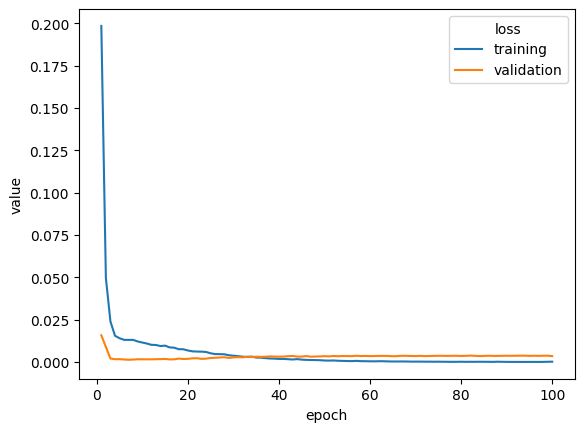

In [265]:
losses = pd.DataFrame(losses)

sns.lineplot(
    data=losses.melt(id_vars="epoch", var_name="loss"),
    x="epoch",
    y="value",
    hue="loss"
)

In [266]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            targets = targets.unsqueeze(1)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics

In [267]:
metrics = eval(model, test_loader)
metrics

{'MSE': 0.001044114518056934,
 'RMSE': 0.03231276091665542,
 'MAE': 0.021505563519895077}

In [268]:
scale = omax - omin

print(f"Metrics rescaled to original units:\n\nMSE: {metrics['MSE'] * (scale ** 2)}\nRMSE: {metrics['RMSE'] * scale}\nMAE: {metrics['MAE'] * scale}")

Metrics rescaled to original units:

MSE: 19098471416.594147
RMSE: 138197.21927952874
MAE: 91976.3274068255


In [269]:
def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

# Rescaling back to original units (migrants):

def rescale(scaled: list, omin: float, omax: float) -> np.array:
    return [x * (omax - omin) + omin for x in scaled]

In [270]:
predictions, actuals = collect_predictions(model, test_loader)
predictions, actuals = rescale(predictions, omin=omin, omax=omax), rescale(actuals, omin=omin, omax=omax)

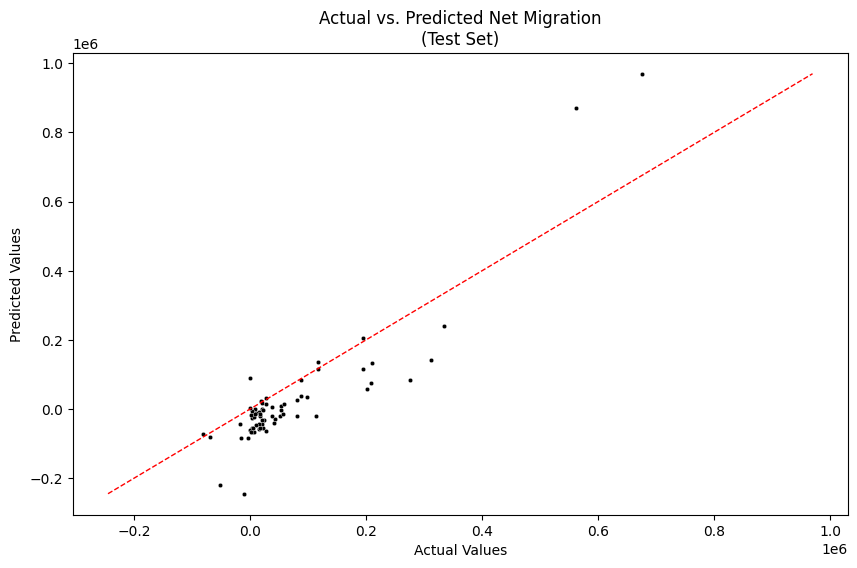

In [271]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()

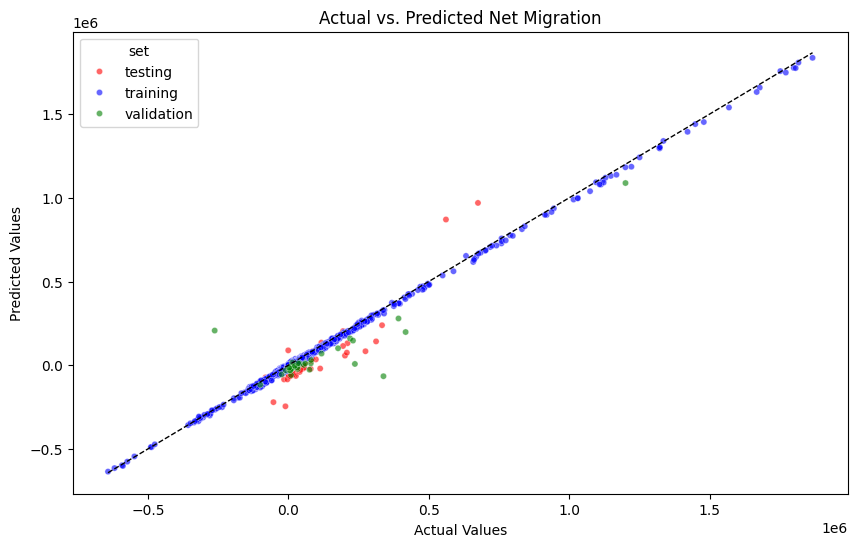

In [272]:
train_pred, train_act = collect_predictions(model, train_loader)
val_pred, val_act = collect_predictions(model, val_loader)

train_pred, train_act = rescale(train_pred, omin, omax), rescale(train_act, omin, omax)
val_pred, val_act = rescale(val_pred, omin, omax), rescale(val_act, omin, omax)

all_predictions = pd.concat([
    pd.DataFrame({"predicted": train_pred, "actual": train_act, "set": "training"}),
    pd.DataFrame({"predicted": val_pred, "actual": val_act, "set": "validation"}),
    pd.DataFrame({"predicted": predictions, "actual": actuals, "set": "testing"})
])

all_predictions['set'] = pd.Categorical(all_predictions['set'], categories=['testing', 'training', 'validation'])
all_predictions = all_predictions.sort_values('set').reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=all_predictions, 
    x="actual",
    y="predicted",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.6
)
# Main diagonal:
min_val = min(min(all_predictions["actual"]), min(all_predictions["predicted"]))
max_val = max(max(all_predictions["actual"]), max(all_predictions["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration')
plt.show()

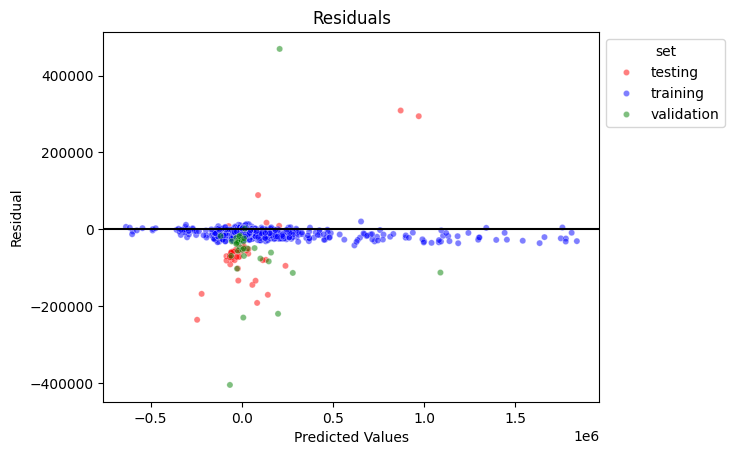

In [273]:
all_predictions["error"] = all_predictions["predicted"] - all_predictions["actual"]
ax = sns.scatterplot(
    data=all_predictions,
    x="predicted",
    y="error",
    hue="set",
    palette={"testing": "red", "training": "blue", "validation": "green"},
    s=20, 
    alpha=0.5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals')
plt.show()